In [ ]:
pip install tensorflow_decision_forests

In [34]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


<ipython-input-35-e59e3216e9fe>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset_df['SalePrice'], color='b', bins=100, hist_kws={'alpha': 0.4});


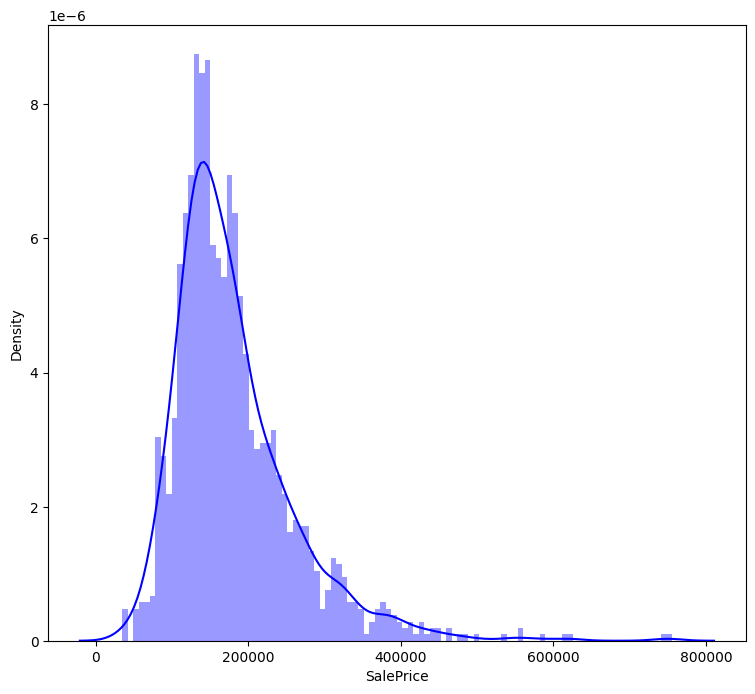

In [35]:
print(dataset_df['SalePrice'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(dataset_df['SalePrice'], color='b', bins=100, hist_kws={'alpha': 0.4});

In [36]:
import numpy as np

def split_dataset(dataset, test_ratio=0.30):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

1020 examples in training, 440 examples in testing.


In [37]:
label = 'SalePrice'
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)

In [39]:
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
rf.compile(metrics=["mse"])

Use /tmp/tmp2o7lhelw as temporary training directory


In [40]:
rf.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:01.165647. Found 1020 examples.
Training model...
Model trained in 0:00:05.933461
Compiling model...
Model compiled.


In [41]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

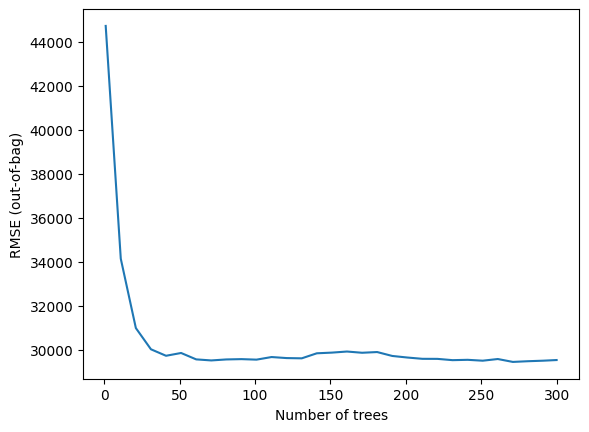

In [42]:
import matplotlib.pyplot as plt
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

In [43]:
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=1020, accuracy=None, loss=None, rmse=29521.370112479173, ndcg=None, aucs=None, auuc=None, qini=None)

In [44]:
evaluation = rf.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 1s 605ms/step - loss: 0.0000e+00 - mse: 713703040.0000
loss: 0.0000
mse: 713703040.0000


In [45]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 SUM_SCORE
	 INV_MEAN_MIN_DEPTH
	 NUM_AS_ROOT
	 NUM_NODES


In [46]:
inspector.variable_importances()["NUM_AS_ROOT"]

[("OverallQual" (1; #62), 113.0),
 ("ExterQual" (4; #22), 59.0),
 ("Neighborhood" (4; #59), 50.0),
 ("GarageCars" (1; #32), 27.0),
 ("GrLivArea" (1; #38), 20.0),
 ("YearBuilt" (1; #76), 13.0),
 ("BsmtQual" (4; #14), 8.0),
 ("GarageArea" (1; #31), 3.0),
 ("KitchenQual" (4; #44), 3.0),
 ("1stFlrSF" (1; #0), 2.0),
 ("FullBath" (1; #29), 1.0),
 ("TotalBsmtSF" (1; #73), 1.0)]

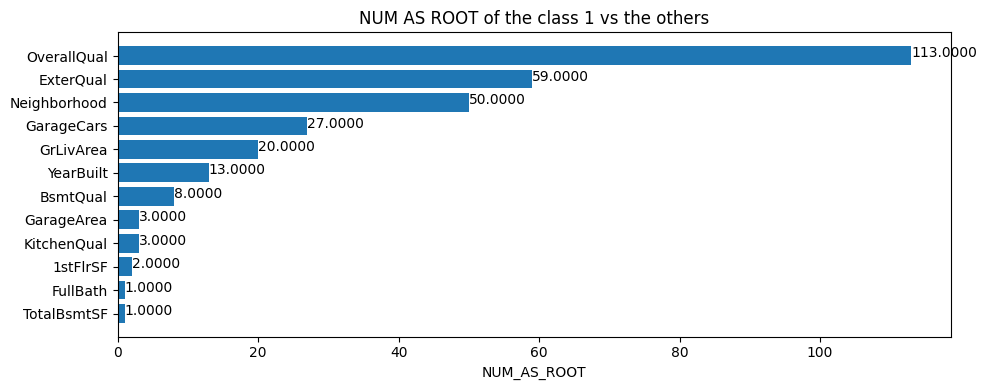

In [60]:
plt.figure(figsize=(10, 4))

# Mean decrease in AUC of the class 1 vs the others.
variable_importance_metric = "NUM_AS_ROOT"
variable_importances = inspector.variable_importances()[variable_importance_metric]

# Extract the feature name and importance values.
#
# `variable_importances` is a list of <feature, importance> tuples.
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
# The feature are ordered in decreasing importance value.
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

# TODO: Replace with "plt.bar_label()" when available.
# Label each bar with values
for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title("NUM AS ROOT of the class 1 vs the others")
plt.tight_layout()
plt.show()